#### Inferences:
1. No null values
2. Very high target class imbalance
3. Very few people (only 1) after 100 years to apply for loan
4. High income people 99% of the time gets approved for the loan
5. Mortgage house people are more likely to be approved for the loan then rented ones
6. Low income people live more in rented houses
7. Very few people with 'person_emp_length' (Employment Tenure) above 50 years
8. All types of 'loan_intent' have almost same probability of getting approved and rejected.
9. A, B, C 'loan_grade' people are more likely to get loan and D, E, F, G people are less likely.
10. No direct relation between loan_amnt and loan_status
11. People with less person_income and more loan_amnt are getting rejected.
12. High interest rates loans are getting rejected more than low ones.
13. 'A' loan_grade people have lesser interest rates and 'G' have the highest (ascending order).
14. High interest rates loans ('D' and below) are getting rejected.
15. 'loan_percent_income' is 'loan_amt' / 'person_income'
16. Approval possiblity more for people with less 'loan_percent_income'
17. The probability of getting accepted reduces when 'Yes' in 'cb_person_default_on_file'

# Imports and some basics to understand the data

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna
from sklearn.ensemble import StackingClassifier

In [2]:
data = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").set_index('id')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
len(data), data.shape

(58645, (58645, 12))

In [4]:
data.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [5]:
for col in data.columns:
    print(col, "--->",data[col].nunique(), '--', data[col].dtype)

person_age ---> 53 -- int64
person_income ---> 2641 -- int64
person_home_ownership ---> 4 -- object
person_emp_length ---> 36 -- float64
loan_intent ---> 6 -- object
loan_grade ---> 7 -- object
loan_amnt ---> 545 -- int64
loan_int_rate ---> 362 -- float64
loan_percent_income ---> 61 -- float64
cb_person_default_on_file ---> 2 -- object
cb_person_cred_hist_length ---> 29 -- int64
loan_status ---> 2 -- int64


In [6]:
data['loan_status'].value_counts()

# Very high class imbalance

loan_status
0    50295
1     8350
Name: count, dtype: int64

# Exploratory Data Analysis

### Column - 'person_age' - Age of the person

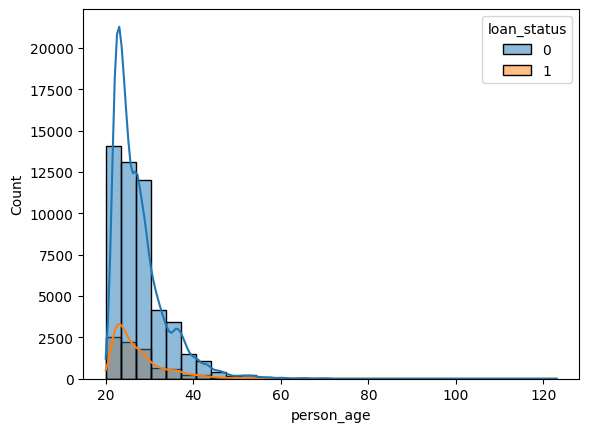

In [7]:
sns.histplot(data=data, x='person_age', hue='loan_status', bins=30, kde=True);

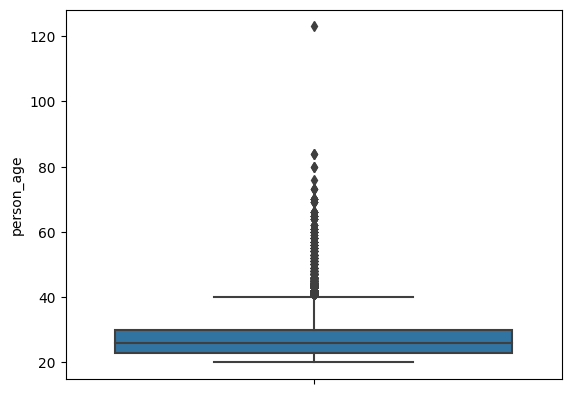

In [8]:
sns.boxplot(data=data, y='person_age');

In [9]:
data = data[data['person_age'] <= 100]    # Since very few people live after 100

In [10]:
data[data['person_age'] > 50]['loan_status'].value_counts()

loan_status
0    404
1     97
Name: count, dtype: int64

### Column - 'person_income' - Income of the person

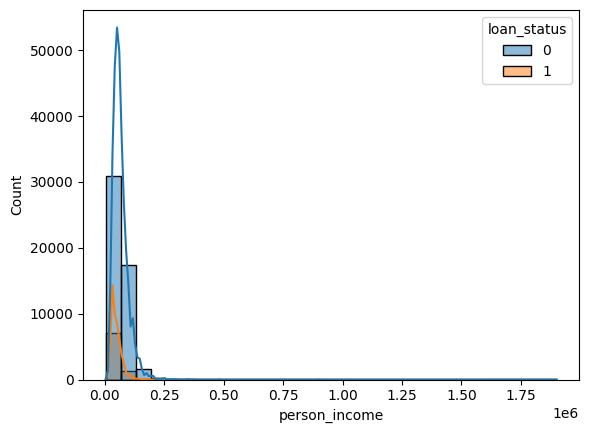

In [11]:
sns.histplot(data=data, x='person_income', hue='loan_status', bins=30, kde=True);

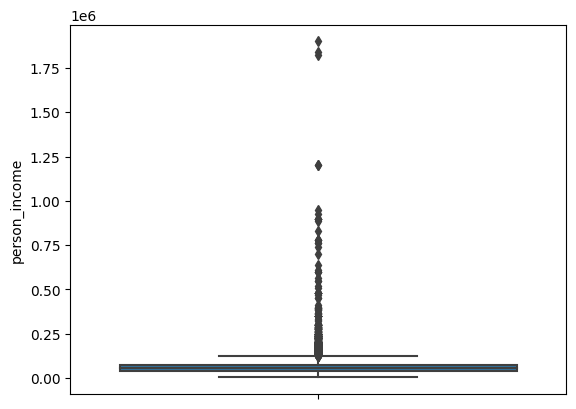

In [12]:
sns.boxplot(data=data, y='person_income');

In [13]:
data[data['person_income'] > 0.25e6]['loan_status'].value_counts()

# People with income above 0.25e6 have very very less chance of getting rejected.

loan_status
0    110
1      3
Name: count, dtype: int64

In [14]:
data = data[data['person_income'] < 1.75e6]

### Column - 'person_home_ownership' - Type of ownership of the house (rent, own, etc)

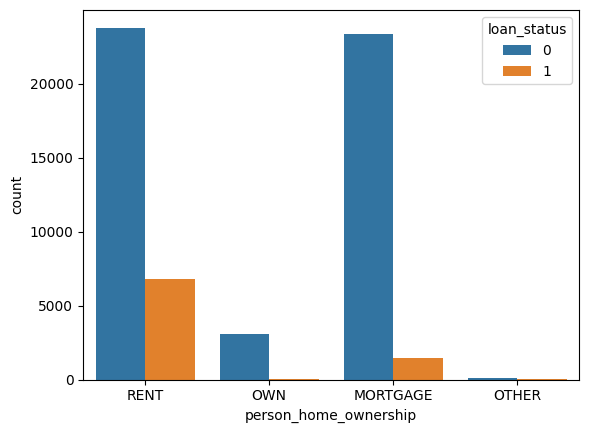

In [15]:
sns.countplot(data=data, x='person_home_ownership', hue='loan_status');

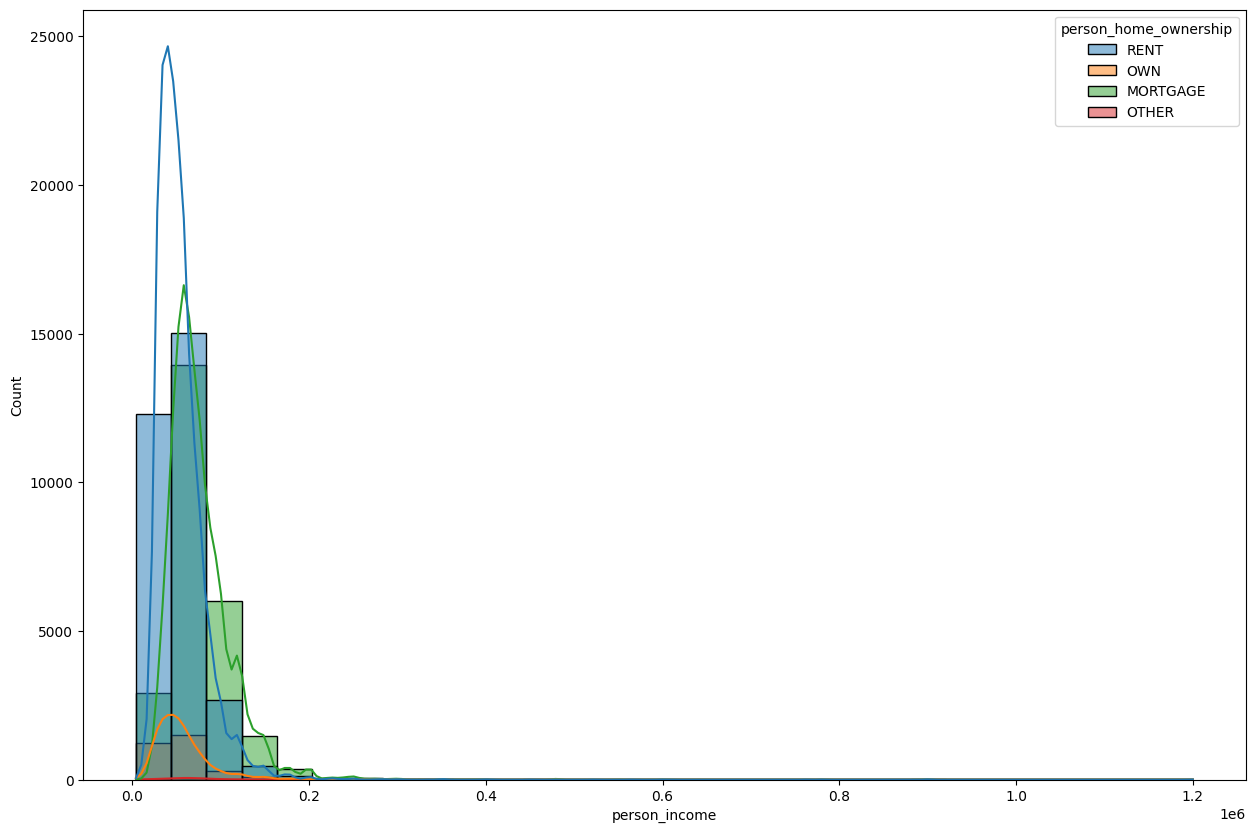

In [16]:
plt.figure(figsize=(15, 10))
sns.histplot(data=data, x='person_income', hue='person_home_ownership', kde=True, bins=30);

In [17]:
# Low income people often live in rented house more.

### Column - 'person_emp_length' - Employment tenure of the person

In [18]:
data['person_emp_length'].value_counts()

person_emp_length
0.0      7585
2.0      7270
3.0      6475
5.0      5839
4.0      5461
1.0      5203
6.0      4901
7.0      4274
8.0      3014
9.0      2290
11.0     1491
12.0     1105
10.0     1072
13.0      797
14.0      590
15.0      367
16.0      280
17.0      168
18.0      153
21.0       78
19.0       72
20.0       65
22.0       20
24.0       14
23.0       12
26.0       11
25.0        8
27.0        7
31.0        5
28.0        4
30.0        2
123.0       2
41.0        2
29.0        2
35.0        1
39.0        1
Name: count, dtype: int64

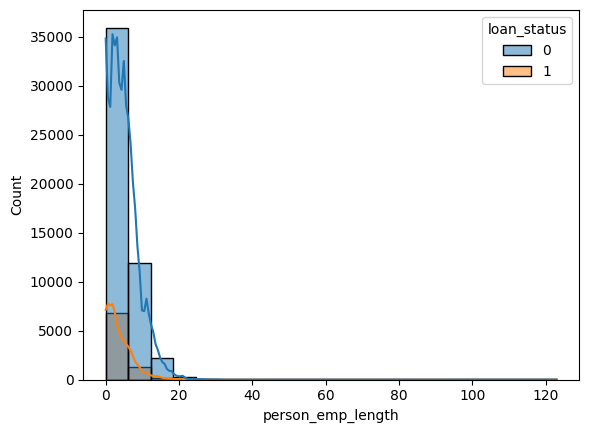

In [19]:
sns.histplot(data=data, x='person_emp_length', hue='loan_status',kde=True, bins=20);

<Axes: ylabel='person_emp_length'>

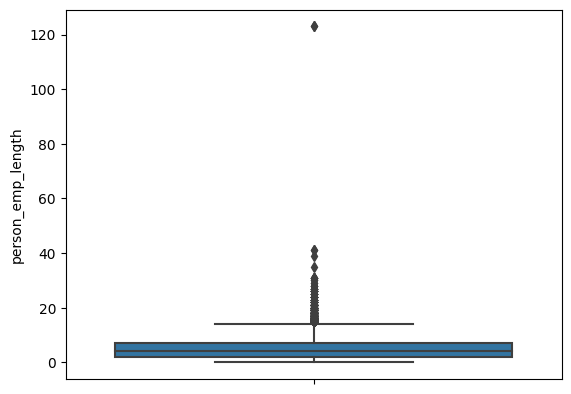

In [20]:
sns.boxplot(data=data, y='person_emp_length')

In [21]:
data = data[data['person_emp_length'] < 50]

### Column - 'loan_intent' - purpose of the loan

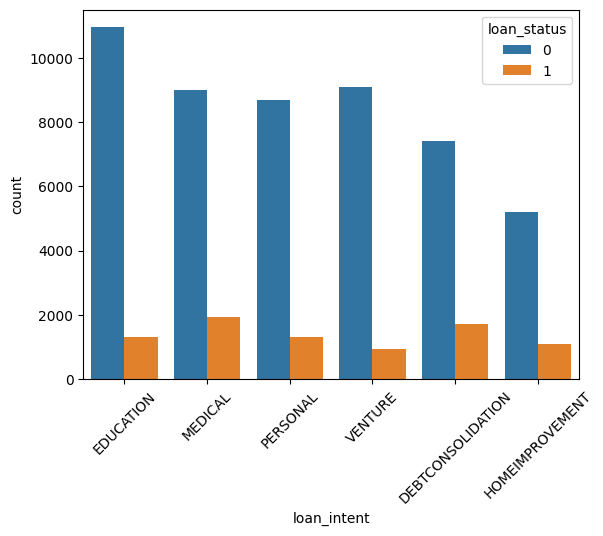

In [22]:
sns.countplot(data=data, x='loan_intent', hue='loan_status')
plt.xticks(rotation=45);

### Column - 'loan_grade' - Creditworthiness/Risk level of the loan applier

* A - Low risk, low interest rates
* B - Moderate risk, moderatae interest rates
* C - Average risk, high interest rates
* D - Above average risk, even higher interest rates
* E and below - High risk, very high interest rates

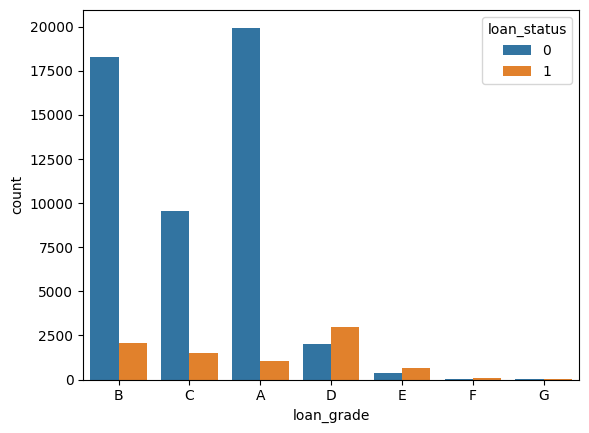

In [23]:
sns.countplot(data=data, x='loan_grade', hue='loan_status');

In [24]:
# A, B, C people more likely to get loan (A being highest) and D, E, F, G people less likely to get loan (G being lowest)
# Maybe create a column after this iteration with binary outputs like 'grade_above_C'

### Column - 'loan_amnt' - The amount of the loan

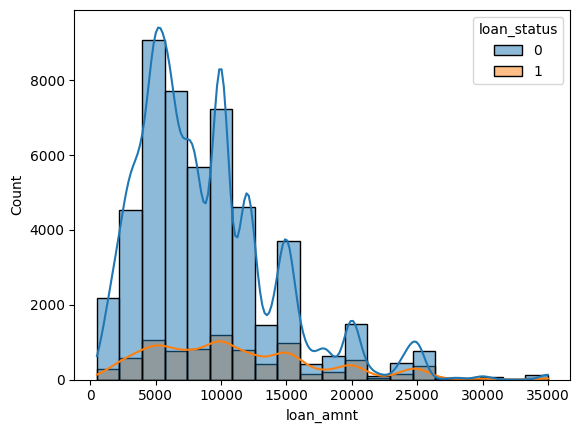

In [25]:
sns.histplot(data=data, x='loan_amnt', hue='loan_status', kde=True, bins=20);

# No direct relation between loan_amnt and loan_status as banks have a lot of money

<Figure size 1000x800 with 0 Axes>

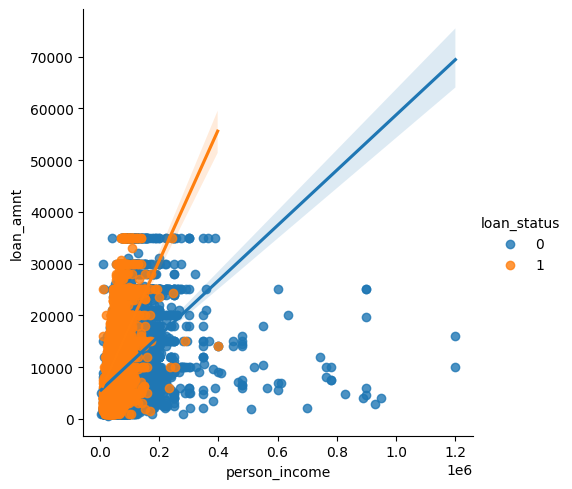

In [26]:
# Relation between person_income and loan_amnt with hue of loan_status
plt.figure(figsize=(10, 8))
sns.lmplot(data=data, x='person_income', y='loan_amnt', hue='loan_status')
plt.show();

In [27]:
# People with less person_income and more loan_amnt are getting rejected.
# People with high person_income are getting both high and less value loans.

### Column - 'loan_int_rate' - Interest rate on the loan applied

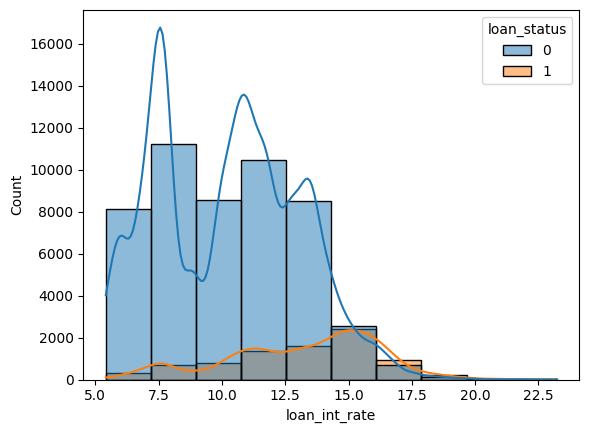

In [28]:
sns.histplot(data=data, x='loan_int_rate', hue='loan_status',bins=10, kde=True);

In [29]:
# High interest rate loans are getting rejected more than the low ones
# Not getting loans with high interest rates are left skewed

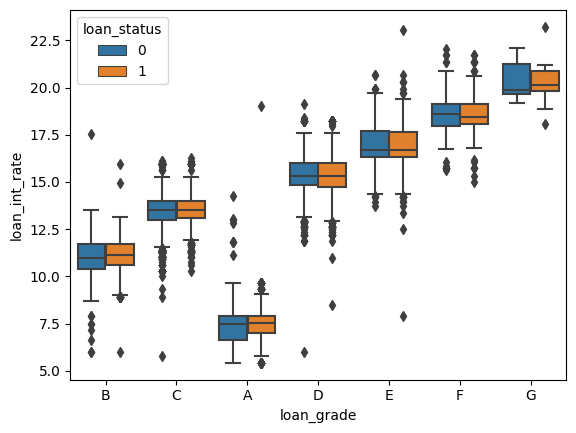

In [30]:
# Trying out relations between loan_grade and loan_int_rate

sns.boxplot(data=data, x='loan_grade', y='loan_int_rate', hue='loan_status');

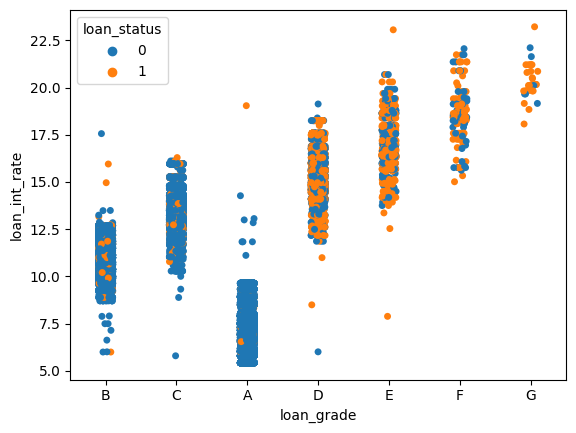

In [31]:
sns.stripplot(data=data, x='loan_grade', y='loan_int_rate', hue='loan_status');

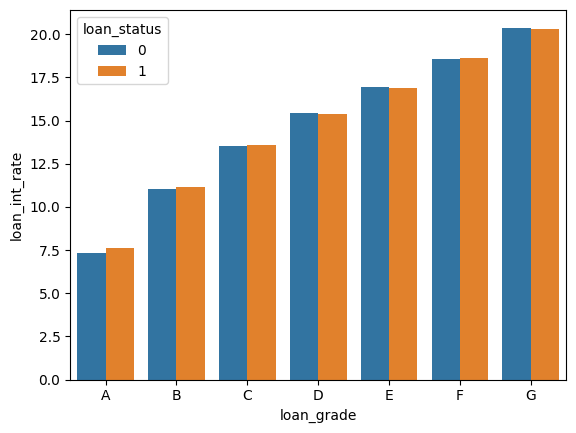

In [32]:
# Example of aggregating the data
aggregated_data = data.groupby(['loan_grade', 'loan_status'])['loan_int_rate'].mean().reset_index()
sns.barplot(x='loan_grade', y='loan_int_rate', hue='loan_status', data=aggregated_data);

In [33]:
# Work more on those 2 columns in next iterations.

### Column - 'loan_percent_income' - percentage of borrower's income that is used to pay the loan
* loan_percent_income = loan_amt / person_income

<Axes: xlabel='loan_percent_income', ylabel='Count'>

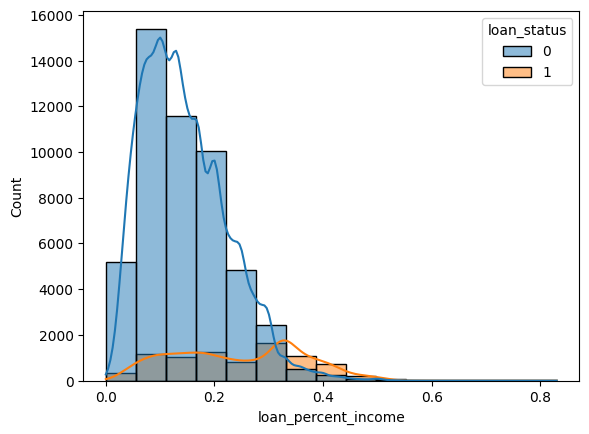

In [34]:
sns.histplot(data=data, x='loan_percent_income', hue='loan_status', kde=True, bins=15)

In [35]:
# Approval more for people with less 'loan_percent_income'
# Approval loan_status with 'loan_percnt_income' is right skewed

### Column - 'cb_person_default_on_file'

* 'cb_person_default_on_file' - whether a person (applier) has a default recorded in their credit history.

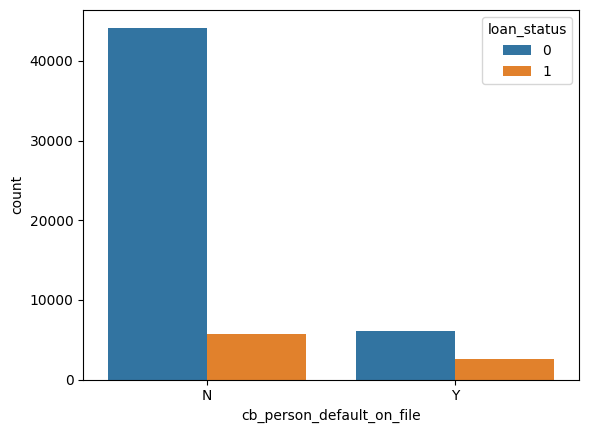

In [36]:
sns.countplot(data=data, x='cb_person_default_on_file', hue='loan_status');

In [37]:
# Not able to find any inference with this column. (still getting if yes or not)
# Only can draw that if 'Yes', the, probability of getting accepted reduces.
# Work on it more in next iterations

### Column - 'cb_person_cred_hist_length '

* 'cb_person_cred_hist_length ' - length of an individual's credit history

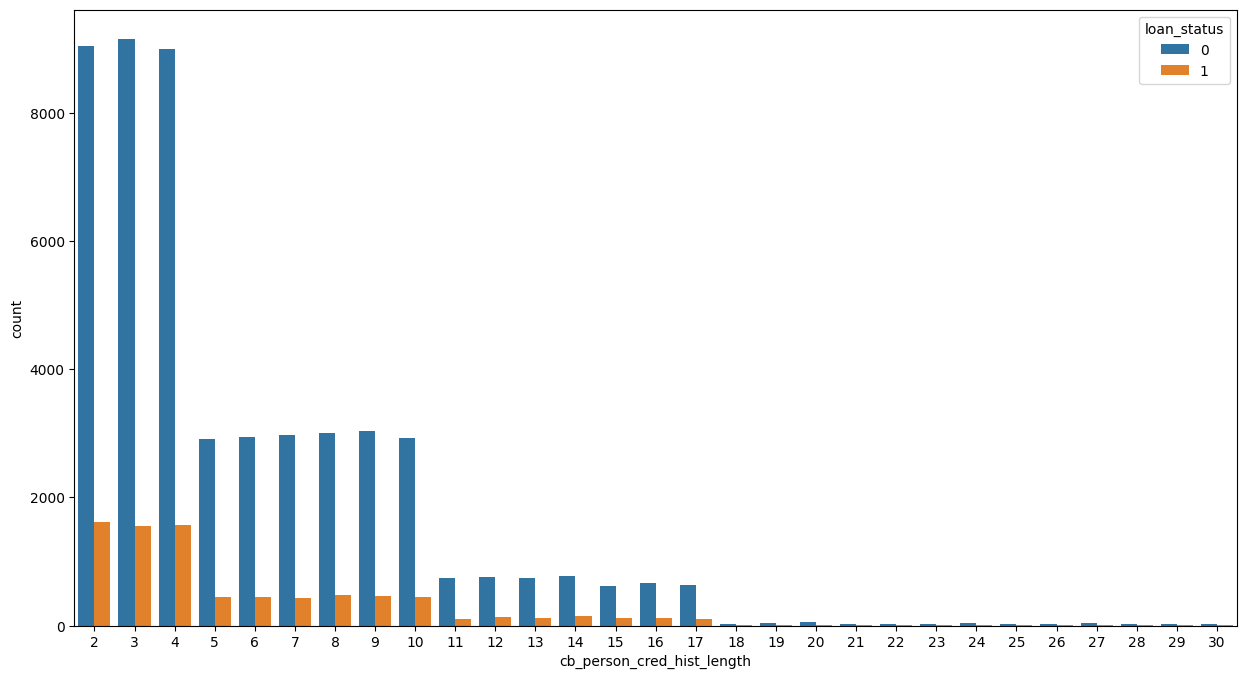

In [38]:
plt.figure(figsize=(15, 8))
sns.countplot(data=data, x='cb_person_cred_hist_length', hue='loan_status');

In [39]:
# Low credit history people are applying more for the loan

In [40]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Preprocessing the data

In [41]:
# Try out binning age column in next iteration

In [42]:
obj_cols = ['person_home_ownership', 'person_home_ownership', 'loan_intent', 'loan_grade', 
            'cb_person_default_on_file']

num_cols = ['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 
            'loan_percent_income', 'cb_person_cred_hist_length']

target_column = 'loan_status'

In [43]:
baseline_models = {
    'Logistic_Regression' : LogisticRegression(),
    'Naive_Bayes_Gaussian' : GaussianNB(),
    'KNN' : KNeighborsClassifier(),
    'Decision_Trees' : DecisionTreeClassifier(),
    'Random_Forest' : RandomForestClassifier(),
    'Gradient_Boosting' : GradientBoostingClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
#     'SVC' : SVC(probability=True),     # Takes too much time, less score
    'XGBoost' : XGBClassifier(),
    'CatBoost' : CatBoostClassifier(silent=True),
    'LightGBM' : LGBMClassifier(verbosity=0)
}

In [106]:
def preprocess(data, training=True, test_data=None, show_baselines=True):
    if training == True :
        X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column],
                                                            test_size=0.2, stratify=data[target_column], shuffle=True,
                                                            random_state=42)
        
        for col in obj_cols:
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
            print(f"Label Encoded Column {col}.")
            
        scaler = StandardScaler()
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_test[num_cols] = scaler.transform(X_test[num_cols])
        print("Standard Scaling Done.")
        
        print(X_train.head())
        
        
        results_df = pd.DataFrame(columns=['Model_Name', 'Accuracy_Score', 'ROC_AUC_Score'])
        
        for name, model in baseline_models.items():
            clf = model
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            probs = clf.predict_proba(X_test)
            
            accuracy = accuracy_score(y_test, preds)
            roc = roc_auc_score(y_test, probs[:, 1])
            
            if show_baselines == True:
                print("*"*50)
                print("-"*30)
                print(f"{name}")
                print("-"*30)
                print(f"Accuracy Score : {accuracy}")
                print(f"ROC AUC Score : {roc}\n")
            
            new_results_df = pd.DataFrame({
                'Model_Name': [name],
                'Accuracy_Score': [accuracy],
                'ROC_AUC_Score': [roc]
            })
            
            results_df = pd.concat([results_df, new_results_df], ignore_index=True)
        return results_df, X_train, X_test, y_train, y_test
    
    if training==False and test_data is not None:
        for col in obj_cols:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            test_data[col] = le.transform(test_data[col])
            print(f"Label Encoded Column {col}.")
            
        scaler = StandardScaler()
        data[num_cols] = scaler.fit_transform(data[num_cols])
        test_data[num_cols] = scaler.transform(test_data[num_cols])
        print("Standard Scaling Done.")
            
        return data, test_data

In [107]:
baseline_results, _, _, _, _ = preprocess(data, training=True, test_data=None, show_baselines=True)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.
       person_age  person_income  person_home_ownership  person_emp_length  \
18548          23       0.197448                      2           0.592737   
24867          24      -0.359141                      0          -0.948830   
55557          27      -1.221854                      2          -0.948830   
19667          29      -0.247824                      0          -0.948830   
36857          28      -0.108676                      3           1.877377   

       loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
18548            3           2   1.406004       1.046771             1.098098   
24867            3           3   0.145169       1.849982             0.445048   
55557            5           1  -0.755428      -0.069167      

In [108]:
baseline_results.sort_values(by='ROC_AUC_Score', ascending=False)

,Model_Name,Accuracy_Score,ROC_AUC_Score
9,LightGBM,0.952170,0.957819
8,CatBoost,0.952937,0.957053
7,XGBoost,0.950976,0.952914
5,Gradient_Boosting,0.946287,0.941619
4,Random_Forest,0.949015,0.932483
6,AdaBoost,0.928553,0.923003
0,Logistic_Regression,0.898542,0.883525
1,Naive_Bayes_Gaussian,0.849604,0.871889
2,KNN,0.921221,0.863644
3,Decision_Trees,0.909796,0.826808


----

# XGBoost

## Baseline XGBoost model and prediction on test_data

In [109]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop('id', axis=1)
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [110]:
data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [111]:
data, test_data = preprocess(data=data, training=False, test_data=test_data, show_baselines=False)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.


In [112]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,-0.765768,3,-1.187200,1,1,-0.578306,0.267616,0.117378,0,2.031798,0
1,22,-0.212128,2,0.328047,3,2,-0.937775,0.880532,-0.973242,0,-0.946489,0
2,29,-0.929223,2,0.833130,4,0,-0.578306,-0.585854,0.553626,0,1.039036,0
3,30,0.156966,3,2.348377,5,1,0.500101,0.142396,0.117378,0,-0.201917,0
4,22,-0.106673,3,-0.682117,3,0,-0.578306,-1.238314,-0.646056,0,-0.698298,0


In [113]:
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,0.130602,3,-0.429576,2,5,2.836651,1.674687,2.189555,0,-0.946489
1,26,0.842425,0,0.328047,4,2,0.140632,0.659750,-0.646056,1,-0.450108
2,26,-0.897587,3,0.075506,5,4,-0.937775,2.145908,-0.318870,1,-0.946489
3,33,-0.370311,3,-0.177035,0,0,-0.398572,-0.585854,-0.209808,0,0.294464
4,26,1.000608,0,0.833130,2,3,1.039305,1.859221,-0.100746,1,-0.450108


In [114]:
xgb_baseline = XGBClassifier()
xgb_baseline.fit(data.drop('loan_status', axis=1), data['loan_status'])
preds = xgb_baseline.predict_proba(test_data)
print("Done")

Done


In [115]:
len(preds)

39098

In [116]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sub['loan_status'] = preds[:, 1]
sub.to_csv('xgb_baseline_1.csv', index=False)
sub.head()

,id,loan_status
0,58645,0.996086
1,58646,0.030993
2,58647,0.599582
3,58648,0.010007
4,58649,0.041040


---

## Optuna for XGBoost

In [117]:
_, X_train, X_test, y_train, y_test = preprocess(data=data, training=True, test_data=None, show_baselines=False)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.
       person_age  person_income  person_home_ownership  person_emp_length  \
18548          23       0.197448                      2           0.592737   
24867          24      -0.359141                      0          -0.948830   
55557          27      -1.221854                      2          -0.948830   
19667          29      -0.247824                      0          -0.948830   
36857          28      -0.108676                      3           1.877377   

       loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
18548            3           2   1.406004       1.046771             1.098098   
24867            3           3   0.145169       1.849982             0.445048   
55557            5           1  -0.755428      -0.069167      

In [57]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, preds_proba)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10000, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best ROC AUC score:", study.best_value)

[I 2024-10-01 07:32:29,962] A new study created in memory with name: no-name-61da6565-b6e4-47a9-8f70-d459579f6e24


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-01 07:32:31,858] Trial 0 finished with value: 0.956586737053778 and parameters: {'n_estimators': 242, 'max_depth': 7, 'learning_rate': 0.07220194318463516, 'subsample': 0.9307049268726365, 'colsample_bytree': 0.5931843117475557, 'gamma': 0.9033640307438218}. Best is trial 0 with value: 0.956586737053778.
[I 2024-10-01 07:32:33,502] Trial 1 finished with value: 0.9567671992727935 and parameters: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.11298854476892196, 'subsample': 0.6968305037086586, 'colsample_bytree': 0.7674264188467009, 'gamma': 1.208884979576223}. Best is trial 1 with value: 0.9567671992727935.
[I 2024-10-01 07:32:35,090] Trial 2 finished with value: 0.9572410204940551 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2198869429166791, 'subsample': 0.8447144609695434, 'colsample_bytree': 0.9789914351740157, 'gamma': 1.3565279375674666}. Best is trial 2 with value: 0.9572410204940551.
[I 2024-10-01 07:32:36,404] Trial 3 finished wi

# LightGBM

## Baseline LightGBM and predictions on test_data

In [118]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop('id', axis=1)
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [119]:
data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [120]:
data, test_data = preprocess(data=data, training=False, test_data=test_data, show_baselines=False)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.


In [121]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,-0.765768,3,-1.187200,1,1,-0.578306,0.267616,0.117378,0,2.031798,0
1,22,-0.212128,2,0.328047,3,2,-0.937775,0.880532,-0.973242,0,-0.946489,0
2,29,-0.929223,2,0.833130,4,0,-0.578306,-0.585854,0.553626,0,1.039036,0
3,30,0.156966,3,2.348377,5,1,0.500101,0.142396,0.117378,0,-0.201917,0
4,22,-0.106673,3,-0.682117,3,0,-0.578306,-1.238314,-0.646056,0,-0.698298,0


In [122]:
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,0.130602,3,-0.429576,2,5,2.836651,1.674687,2.189555,0,-0.946489
1,26,0.842425,0,0.328047,4,2,0.140632,0.659750,-0.646056,1,-0.450108
2,26,-0.897587,3,0.075506,5,4,-0.937775,2.145908,-0.318870,1,-0.946489
3,33,-0.370311,3,-0.177035,0,0,-0.398572,-0.585854,-0.209808,0,0.294464
4,26,1.000608,0,0.833130,2,3,1.039305,1.859221,-0.100746,1,-0.450108


In [123]:
lgb_baseline = LGBMClassifier(verbose=0)
lgb_baseline.fit(data.drop('loan_status', axis=1), data['loan_status'])
preds = lgb_baseline.predict_proba(test_data)
print("Done")

Done


In [124]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sub['loan_status'] = preds[:, 1]
sub.to_csv('lgb_baseline_1.csv', index=False)
sub.head()

,id,loan_status
0,58645,0.987634
1,58646,0.015456
2,58647,0.576652
3,58648,0.022526
4,58649,0.066220


## Optuna for LightGBM

In [125]:
_, X_train, X_test, y_train, y_test = preprocess(data=data, training=True, test_data=None, show_baselines=False)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.
       person_age  person_income  person_home_ownership  person_emp_length  \
18548          23       0.197448                      2           0.592737   
24867          24      -0.359141                      0          -0.948830   
55557          27      -1.221854                      2          -0.948830   
19667          29      -0.247824                      0          -0.948830   
36857          28      -0.108676                      3           1.877377   

       loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
18548            3           2   1.406004       1.046771             1.098098   
24867            3           3   0.145169       1.849982             0.445048   
55557            5           1  -0.755428      -0.069167      

In [127]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 10),  # -1 means no limit
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
        'random_state': 42,
        'verbosity' : -1
    }
    
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    preds_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, preds_proba)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best ROC AUC score:", study.best_value)

[I 2024-10-01 07:56:37,267] A new study created in memory with name: no-name-02bb591b-5d4f-4af4-bb48-992440960fcd


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-01 07:56:37,730] Trial 0 finished with value: 0.9492506487174771 and parameters: {'n_estimators': 62, 'max_depth': 3, 'learning_rate': 0.29062038277363034, 'subsample': 0.6984899651164511, 'colsample_bytree': 0.6444485525954475, 'lambda_l1': 4.701780106561494, 'lambda_l2': 1.0427213783819367}. Best is trial 0 with value: 0.9492506487174771.
[I 2024-10-01 07:56:39,045] Trial 1 finished with value: 0.9589536703509177 and parameters: {'n_estimators': 145, 'max_depth': -1, 'learning_rate': 0.11535299154272227, 'subsample': 0.6835265432908215, 'colsample_bytree': 0.6141621721706935, 'lambda_l1': 4.487692128153202, 'lambda_l2': 4.857700179430575}. Best is trial 1 with value: 0.9589536703509177.
[I 2024-10-01 07:56:40,314] Trial 2 finished with value: 0.9606783450694792 and parameters: {'n_estimators': 149, 'max_depth': 8, 'learning_rate': 0.10439286750065845, 'subsample': 0.7905104005682222, 'colsample_bytree': 0.6146166526056387, 'lambda_l1': 3.3856048694126537, 'lambda_l2': 0.73

----

# CatBoost

## Baseline CatBoost and prediction on test_data

In [86]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop('id', axis=1)
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [87]:
data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [88]:
data, test_data = preprocess(data=data, training=False, test_data=test_data)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.


In [89]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,-0.765768,3,-1.187200,1,1,-0.578306,0.267616,0.117378,0,2.031798,0
1,22,-0.212128,2,0.328047,3,2,-0.937775,0.880532,-0.973242,0,-0.946489,0
2,29,-0.929223,2,0.833130,4,0,-0.578306,-0.585854,0.553626,0,1.039036,0
3,30,0.156966,3,2.348377,5,1,0.500101,0.142396,0.117378,0,-0.201917,0
4,22,-0.106673,3,-0.682117,3,0,-0.578306,-1.238314,-0.646056,0,-0.698298,0


In [90]:
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,0.130602,3,-0.429576,2,5,2.836651,1.674687,2.189555,0,-0.946489
1,26,0.842425,0,0.328047,4,2,0.140632,0.659750,-0.646056,1,-0.450108
2,26,-0.897587,3,0.075506,5,4,-0.937775,2.145908,-0.318870,1,-0.946489
3,33,-0.370311,3,-0.177035,0,0,-0.398572,-0.585854,-0.209808,0,0.294464
4,26,1.000608,0,0.833130,2,3,1.039305,1.859221,-0.100746,1,-0.450108


In [91]:
cat_baseline = CatBoostClassifier(verbose=0)
cat_baseline.fit(data.drop('loan_status', axis=1), data['loan_status'])
preds = cat_baseline.predict_proba(test_data)
print("Done")

Done


In [92]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sub['loan_status'] = preds[:, 1]
sub.to_csv('cat_baseline_1.csv', index=False)
sub.head()

,id,loan_status
0,58645,0.998068
1,58646,0.023602
2,58647,0.672104
3,58648,0.010025
4,58649,0.058919


## Optuna for CatBoost

In [129]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-6, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    preds_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, preds_proba)
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best ROC AUC score:", study.best_value)

[I 2024-10-01 08:00:33,925] A new study created in memory with name: no-name-f7029b61-cf19-4490-a3b3-c185586a3dc8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-10-01 08:00:35,719] Trial 0 finished with value: 0.9484098906273346 and parameters: {'iterations': 144, 'depth': 9, 'learning_rate': 0.2044575321343881, 'l2_leaf_reg': 5.02907774082739, 'subsample': 0.8331491451428568, 'colsample_bylevel': 0.5472018009216241}. Best is trial 0 with value: 0.9484098906273346.
[I 2024-10-01 08:00:36,221] Trial 1 finished with value: 0.9459705105149082 and parameters: {'iterations': 73, 'depth': 6, 'learning_rate': 0.2761200969259699, 'l2_leaf_reg': 6.5727666962436695, 'subsample': 0.6327775550878356, 'colsample_bylevel': 0.5681597336247882}. Best is trial 0 with value: 0.9484098906273346.
[I 2024-10-01 08:00:37,460] Trial 2 finished with value: 0.9455263347447662 and parameters: {'iterations': 98, 'depth': 9, 'learning_rate': 0.20001218337582946, 'l2_leaf_reg': 5.156821709487414, 'subsample': 0.8638952411833003, 'colsample_bylevel': 0.8196793737820693}. Best is trial 0 with value: 0.9484098906273346.
[I 2024-10-01 08:00:38,264] Trial 3 finished wi

-----

# Easy Optuna Stacked

## Coding Stacked

In [131]:
data = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv").drop('id', axis=1)
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [132]:
_, X_train, X_test, y_train, y_test = preprocess(data=data, training=True, test_data=None, show_baselines=False)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.
       person_age  person_income  person_home_ownership  person_emp_length  \
18548          23       0.197448                      2           0.592737   
24867          24      -0.359141                      0          -0.948830   
55557          27      -1.221854                      2          -0.948830   
19667          29      -0.247824                      0          -0.948830   
36857          28      -0.108676                      3           1.877377   

       loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
18548            3           2   1.406004       1.046771             1.098098   
24867            3           3   0.145169       1.849982             0.445048   
55557            5           1  -0.755428      -0.069167      

In [135]:
easy_xgb_params = {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.11265145490586516, 
                   'subsample': 0.9391777396305679, 'colsample_bytree': 0.6039540118041746, 
                   'gamma': 0.1862600570016656}
easy_lgb_params = {'n_estimators': 266, 'max_depth': 10, 'learning_rate': 0.08442720186138244, 
                   'subsample': 0.6827429959831401, 'colsample_bytree': 0.7961763176155671, 
                   'lambda_l1': 0.46337005072570864, 'lambda_l2': 3.180652039305612, 'verbosity' : -1}
easy_cat_params = {'iterations': 249, 'depth': 5, 'learning_rate': 0.26357764672534284, 
                   'l2_leaf_reg': 7.525715842052501, 'subsample': 0.7662419881611896, 
                   'colsample_bylevel': 0.8885787324509806, 'verbose': False}

easy_xgb = XGBClassifier(**easy_xgb_params)
easy_lgb = LGBMClassifier(**easy_lgb_params)
easy_cat =  CatBoostClassifier(**easy_cat_params)

meta_model = LogisticRegression()

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', easy_xgb),
        ('cat', easy_cat),
        ('lgb', easy_lgb)
    ],
    final_estimator=meta_model,
    cv=3
)

stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob[:, 1])
print(f"Stacking Classifier Accuracy: {accuracy:.4f} %")
print(f"Stacking Classifier ROC AUC Score: {roc:.4f} %")

Stacking Classifier Accuracy: 0.9523 %
Stacking Classifier ROC AUC Score: 0.9595 %


## Predictions on stacked

In [136]:
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop('id', axis=1)
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [137]:
data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop('id', axis=1)
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [138]:
data, test_data = preprocess(data=data, training=False, test_data=test_data, show_baselines=False)

Label Encoded Column person_home_ownership.
Label Encoded Column person_home_ownership.
Label Encoded Column loan_intent.
Label Encoded Column loan_grade.
Label Encoded Column cb_person_default_on_file.
Standard Scaling Done.


In [139]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,-0.765768,3,-1.187200,1,1,-0.578306,0.267616,0.117378,0,2.031798,0
1,22,-0.212128,2,0.328047,3,2,-0.937775,0.880532,-0.973242,0,-0.946489,0
2,29,-0.929223,2,0.833130,4,0,-0.578306,-0.585854,0.553626,0,1.039036,0
3,30,0.156966,3,2.348377,5,1,0.500101,0.142396,0.117378,0,-0.201917,0
4,22,-0.106673,3,-0.682117,3,0,-0.578306,-1.238314,-0.646056,0,-0.698298,0


In [140]:
test_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,0.130602,3,-0.429576,2,5,2.836651,1.674687,2.189555,0,-0.946489
1,26,0.842425,0,0.328047,4,2,0.140632,0.659750,-0.646056,1,-0.450108
2,26,-0.897587,3,0.075506,5,4,-0.937775,2.145908,-0.318870,1,-0.946489
3,33,-0.370311,3,-0.177035,0,0,-0.398572,-0.585854,-0.209808,0,0.294464
4,26,1.000608,0,0.833130,2,3,1.039305,1.859221,-0.100746,1,-0.450108


In [144]:
stacking_clf.fit(data.drop('loan_status', axis=1), data['loan_status'])
print("Done")

preds = stacking_clf.predict_proba(test_data)
print(preds[:5])

Done
[[0.01729396 0.98270604]
 [0.97270625 0.02729375]
 [0.32016436 0.67983564]
 [0.97443856 0.02556144]
 [0.96363131 0.03636869]]


In [145]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sub['loan_status'] = preds[:, 1]
sub.to_csv('easy_optuna_stacked_1.csv', index=False)
sub.head()

,id,loan_status
0,58645,0.982706
1,58646,0.027294
2,58647,0.679836
3,58648,0.025561
4,58649,0.036369
